## Tuning curves
  
    

In [ ]:
!pip install ipywidgets


In [ ]:
!jupyter labextension list

In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np
from scipy import stats as sps 
import numpy.fft as ft
from scipy import signal as sig
from scipy import io
import scipy.io.wavfile as wav
#from scipy.linalg import toeplitz
from math import *
from random import randrange, uniform

from threading import Event
import matplotlib


Our filter design is taken from Appendix B, Cochlear filter design, of K. Wang and S. Shamma. Zero-crossing and noise suppression in auditory wavelet transformations. Technical Report ISR; TR 1992-94, Systems Research Center and Department of Electrical Engineering, University of Maryland, 1992.

Continuous time frequency response $H(\omega)$ is described from this equation:

$$
H(\omega) = (\omega_c - \omega)^a\, e^{-b(\omega_c - \omega)},  0 \leqslant \omega \leqslant \omega_c, 
$$

and $H(\omega) = 0$ for $\omega > \omega_c$. As it is a Fourier Transform of a real a continuous function also $H(-\omega) = H(\omega)$. 
$a$ and $b$ parameters define macroscopic properties, as $\omega_p = \omega_c - a/b$,  and filter bandwidth $df = 1/b$. 

For the discrete time filter formulation, the previous continuous frequency response is sampled, and an inverse Discrete Fourier Transform is applied, obtaining `h_coc`. This method to produce a discrete time filter from a continuous one, can carry many artifacts. For example, sampling frequency interval is critical, as the effect of performing such operation in frequency generates Gibbs phenomena in the Discrete Frequency response obtained. So, as this filter is very steep, its actual continuous frequency response look like in the following figure. Therefore, as this filter is a Finite response one, whose order is the same a the number of samples in frequency, there is a compromise between filter order and closeness to the continuous design. 


In [2]:
def hn_cochlear(lh = 2048,
                Fs = 16000,
                df = 25./np.log(np.sqrt(2.)),
                fz = 2000.,
                fp_minus_fz = 10.*np.log(2.)/np.log(np.sqrt(2.))):

# df: filter bandwidth
# fz: Cutoff filter frequency 
# fp_minus_fz: frequency distance from peak to zero frequency 

    b = 1/(2.*np.pi*df)
    a = fp_minus_fz*2*np.pi*b
    om = np.linspace(0,Fs,int(lh),endpoint=False)*2*np.pi

    Hd = np.zeros(int(lh))
    Hd[om < fz*2.*np.pi] = (2*np.pi*fz - om[om < fz*2.*np.pi])**a*\
        np.exp(-b*(2*np.pi*fz - om[om < fz*2.*np.pi]))
    Hd = Hd+ Hd[-1::-1]
    tmp = np.fft.ifft(Hd)
    hd = np.fft.fftshift(tmp)

    return( hd )


### Filter specifications:

Cutoff freq fz = 2000.0
Peak frequency distance to cutoff = 0.19999999999999996
Band width = 144.26950408889633


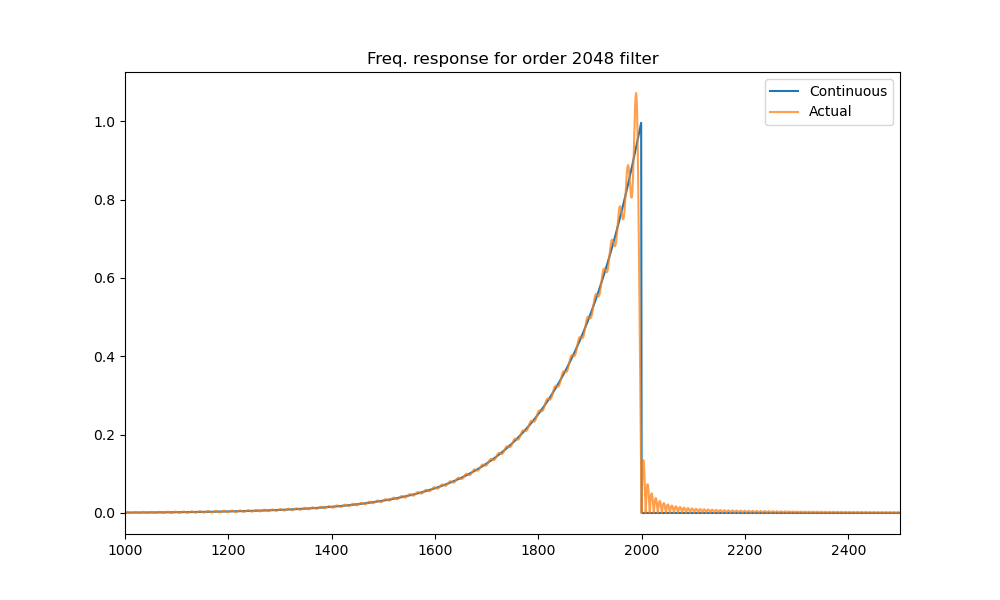

In [3]:
# Filter order
N = 2048
# Sampling frequency
Fs = 16000;
fz = 2000.
df = 50./log(sqrt(2))
# fp_minus_fz = 10.*np.log(2.)/np.log(np.sqrt(2.))
fp_minus_fz = .1*np.log(2.)/np.log(np.sqrt(2.))
print('Cutoff freq fz = {}'.format(fz))
print('Peak frequency distance to cutoff = {}'.format(fp_minus_fz))
print('Band width = {}'.format(df))
#Discrete time filter impulsive response:
hn = hn_cochlear(N,Fs,df,fz,fp_minus_fz)

# Continuos freq response 
b = 1/(2*pi*df)
a = fp_minus_fz*2*np.pi*b
Ncont = 2**14
om_c = np.linspace(0,Fs,Ncont,endpoint=False)*2*np.pi
H_cont = np.zeros(Ncont)
H_cont[om_c < fz*2.*np.pi] = (2*np.pi*fz - om_c[om_c < fz*2.*np.pi])**a*\
    np.exp(-b*(2*np.pi*fz - om_c[om_c < fz*2.*np.pi]))
H_cont = H_cont + H_cont[-1::-1]

#Actual filter freq. response:
H_v2 = np.fft.fft(hn, Ncont)
fig,ax = plt.subplots(figsize= (10.0, 6.0))
ax.plot(om_c/(2*np.pi),H_cont)
ax.plot(om_c/(2*np.pi),np.abs(H_v2),alpha=0.75)
ax.set_xlim(1000,2500)
ax.set_title('Freq. response for order {} filter'.format(N))
ax.legend(('Continuous','Actual'))

### PLL design:

PLL follows this discrete linerized model, based in a classic implementation of a continuous PLL:

<img src="fig/PLL_lintdiscreto-crop.png" alt="PLL linealizado tiempo discreto Lindsey" width="400"/>

$G_1$ and $G_2$ are parameters derived from their continuos counterpart, as follows:

$$ 
G_0 G_1  = 1 - (\alpha^2 + \beta^2) = 1 - e^{-2\xi \omega_n T_s} $$
$$
G_0 G_2 = 2 - G_0 G_1 - 2 \alpha = 1 - 2 e^{-\xi \omega_n T_s} \cos(\sqrt{(1-\xi^2)}\omega_n T_s) + e^{-2\xi \omega_n T_s}.$$

where $G_0$ is usually defined as $1$

Complete PLL is as shown in the following figure, with all its accesory circuits:


<img src="fig/PLL_bloques-crop.png" alt="Diagrama de bloques del PLL" width="800"/>

where the error voltage $u_d(n)$ is calculated in the discrete version using data from the previous time:

$$
u_d(n) = x(n) . \sin\big(\theta_2(n-1)+\omega_o n T_s\big)
$$ 

with $x(n)$ the input signal, and $\omega_0$  the "free running" frequency, not present in the linealized model. It correspond to the starting frequency for the internal sinusoidal signal. This parameter is intended to be as close as possible to the expected input signal frequency in order to reduce adquisition time. The `loop filter` performs the operation corresponding to the upper block in the first figure, i.e.: 

$$ 
u_f(n) = (G_1 + G_2) . u_d(n) - G_1 u_d(n-1) +  u_f(n-1) 
$$

The `vco` block calculates the internal representation of a sinusoidal signal intended to reproduce the input sinusoid, as is depicted in the lower block of the first figure, where the internal phase is

$$
\theta_2(n) = G_0 . u_f(n) + \theta_2(n-1)
$$

`Lockin filter` is a first order IIR filter, expressed by

$$
lockin(n) = b0 \, u_l(n) + b1 \, u_l(n-1) - a1 \, lockin(n-1)
$$ 

Finally, `Frequency estimation` block, calculates frequency as the inverse of a time interval between a two sucsessive $2\pi\,k$ crosses of $\theta_2(n)$ signal. For higher frecuencies a linear interpolation of the cross time between samples time is performed. This estimation produces a sawtooth $freq(n)$ output, updated only when a change of cycle occurs in $\cos(\omega_0\,n\, T_s+\theta(n))$ phase. Posterior smoothing should be performed between changing cicle time, especially for low frequency detectors. 

#### Implementing integral version of equations:

Actual implementation of PLL is performed replacing difference equations in the integral alternative form:
Eq for $u_f(n)$ 

$$ 
u_f(n) = (G_1 + G_2) . u_d(n) - G_1 u_d(n-1) +  u_f(n-1) 
$$
is replaced by
$$ 
u_f(n) = G_1 . u_d(n) - G_1 . u_d(-1) + u_f(-1) + G_2 \sum_{m=0}^{n} u_d(m)
$$

And eq. for $\theta_d(n)$

$$
\theta_2(n) = G_0 . u_f(n) + \theta_2(n-1)
$$
is replaced by
$$
\theta_2(n) = G_0 .\sum_{m=0}^{n} u_f(m) + \theta_2(-1)
$$

These implementations have experimentally  proved be more stable than their original counterpart. 

In [4]:
# x is the input signal
ltime = int(Fs)
x = np.zeros((1,ltime))
t = np.linspace(0,ltime/Fs,ltime,endpoint=False)


In [5]:
class bank_pll:

    def __init__(self, nplls = 1, ltime=16000, sita=0.7, Fn=200., Fo=1975., fc_lock=4, Fs=16000.):
        self.n_f = 0
        self.N = ltime
        self.Fs = Fs
        #Following variables were being calculated in PLL
        self.ud = np.zeros((nplls,ltime))
        self.ul = np.zeros((nplls,ltime))
        self.ud_int = np.zeros(nplls)
        self.uf = np.zeros((nplls,ltime))
        self.uf_int = np.zeros(nplls)
        self.theta2 = np.zeros((nplls,ltime))
        self.vco = np.zeros((nplls,ltime))
        self.vco90 = np.zeros((nplls,ltime))
        self.vco90[:,-1] = np.ones(nplls)
        self.lock = np.zeros((nplls,ltime))
        self.agc = np.zeros((nplls,ltime))
        self.agc[:,-1] = np.ones(nplls)
        self.time2kpi = np.zeros((nplls,ltime))
        self.freq = np.zeros((nplls,ltime))
        self.nper = np.zeros(nplls)
        self.xprev = np.zeros(nplls)
        
        #Parameters:
        wn = 2*np.pi*Fn/Fs
        self.wo = 2*np.pi*Fo/Fs
        self.G0 = 1.
        self.G1 = (1 - np.exp(-2*sita*wn))/self.G0
        self.G2 = (1 + np.exp(-2*sita*wn) - 2.*np.exp(-sita*wn)*np.cos(wn*np.sqrt(1-sita*sita)))/self.G0
        [b,a] = sig.ellip(N=1,rp=1.01,rs=20,Wn=2*pi*fc_lock,analog=True)
        [self.block,self.alock] = sig.bilinear(b,a,Fs)
        
        
    def section_calc(self,x):
        
        uf_f = self.uf[:,-1]
        ud_f = self.ud[:,-1]
        theta2_f = self.theta2[:,-1]
        
        for n in range(self.N):
        # 1) u_d
            self.ud[:,n] = self.agc[:,n-1]*x[:,n]*self.vco[:,n-1]
            self.ul[:,n] = self.agc[:,n-1]*x[:,n]*self.vco90[:,n-1]
#             self.ud[:,n] = x[:,n]*self.vco[:,n-1]
#             self.ul[:,n] = x[:,n]*self.vco90[:,n-1]
        # 2) u_f:
            self.ud_int += self.ud[:,n]
            self.uf[:,n] = self.G1*(self.ud[:,n]-ud_f[:]) + self.G2*self.ud_int[:] + uf_f[:] 
        # 3) theta2 and vco:
            self.uf_int += self.uf[:,n]
            self.theta2[:,n] = self.G0*self.uf_int[:] + self.wo*(self.n_f+n) + theta2_f[:]
            self.vco[:,n] = np.cos(self.theta2[:,n])
            self.vco90[:,n] = np.cos(self.theta2[:,n] -np.pi/2.)
        # 4) AGC and lock-in calculation: first order IIR filter
            self.lock[:,n] = self.block[0]*self.ul[:,n] + self.block[1]*self.ul[:,n-1] - self.alock[1]*self.lock[:,n-1]
            self.agc[:,n] = 10./np.exp(np.abs(3*np.arctan(0.7*np.abs(self.lock[:,n]))))
        # 5) Freq estimation
            for k in range(self.ud.shape[0]):

                if( (np.floor(np.abs(self.theta2[k,n]/(2*np.pi))) != self.nper[k]) ):
                    self.nper[k] = np.floor(np.abs(self.theta2[k,n])/(2*np.pi))
                    self.time2kpi[k,n] = 1./self.Fs*(self.n_f + n-1 + \
                        np.abs(self.theta2[k,n-1]- 2*np.pi*self.nper[k])/\
                        (np.abs(self.theta2[k,n] - 2*np.pi*self.nper[k])+np.abs(self.theta2[k,n-1]-2*np.pi*self.nper[k])))
                        #last two lines are for better calculation of freq, computing a fraction of Ts interpolating linealy 
                    self.freq[k,n] = 1./(self.time2kpi[k,n] - self.time2kpi[k,n-1])
                else: 
                    self.time2kpi[k,n] = self.time2kpi[k,n-1]
                    self.freq[k,n] = self.freq[k,n-1]

    def section_calc2(self,x):
        
        for n in range(self.N):
        # 1) u_d -> esto es igual
            self.ud[:,n] = self.agc[:,n-1]*x[:,n]*self.vco[:,n-1]
            self.ul[:,n] = self.agc[:,n-1]*x[:,n]*self.vco90[:,n-1]

        # 2) u_f:
            self.uf[:,n] = self.uf[:,n-1] + (self.G1 + self.G2)*x[:,n] - self.G1*self.xprev
            self.xprev = x[:,n]
        # 3) theta2 and vco:
            self.theta2[:,n] = self.G0*self.uf[:,n] + self.theta2[:,n-1]  
            self.vco[:,n] = np.cos(self.theta2[:,n]+ self.wo*(self.n_f+n-1))
            self.vco90[:,n] = np.cos(self.theta2[:,n]+ self.wo*(self.n_f+n-1) -np.pi/2.)
        # 4) AGC and lock-in calculation: first order IIR filter
            self.lock[:,n] = self.block[0]*self.ul[:,n] + self.block[1]*self.ul[:,n-1] - self.alock[1]*self.lock[:,n-1]
            self.agc[:,n] = 10./np.exp(np.abs(3*np.arctan(0.7*np.abs(self.lock[:,n]))))
        # 5) Freq estimation
            for k in range(self.ud.shape[0]):

                if( (np.floor(np.abs(self.theta2[k,n]/(2*np.pi))) != self.nper[k]) ):
                    self.nper[k] = np.floor(np.abs(self.theta2[k,n])/(2*np.pi))
                    self.time2kpi[k,n] = 1./self.Fs*(self.n_f + n-1 + \
                        np.abs(self.theta2[k,n-1]- 2*np.pi*self.nper[k])/\
                        (np.abs(self.theta2[k,n] - 2*np.pi*self.nper[k])+np.abs(self.theta2[k,n-1]-2*np.pi*self.nper[k])))
                        #last two lines are for better calculation of freq, computing a fraction of Ts interpolating linealy 
                    self.freq[k,n] = 1./(self.time2kpi[k,n] - self.time2kpi[k,n-1])
                else: 
                    self.time2kpi[k,n] = self.time2kpi[k,n-1]
                    self.freq[k,n] = self.freq[k,n-1]

In [6]:
# Example of operation of PLL.
# Parameters used for the PLL are those used later in the tuning curve
# Input frequency and amplitude correspond to a coordinate inside the frequency threshold curve,  
A = 1.
f = 1800.
s = A*np.cos(2*np.pi*f*t)
x[0,:] = 0.2*s
pll = bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
pll.section_calc(x)

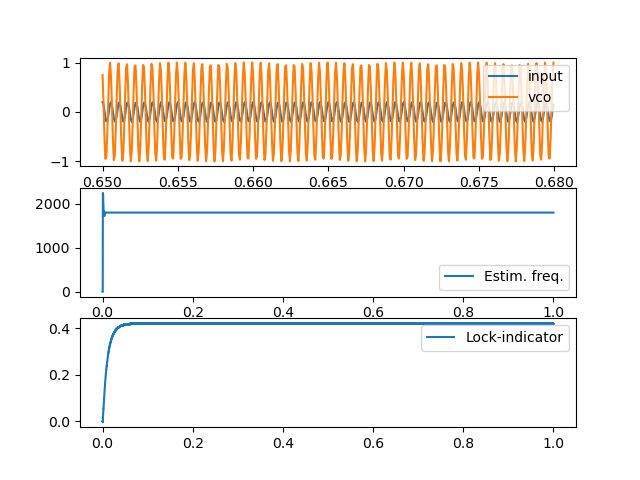

In [7]:
fig,ax = plt.subplots(3,1)
p = 65
ax[0].plot(t[160*p:160*(p+3)],1/A*x[0,160*p:160*(p+3)])
ax[0].plot(t[160*p:160*(p+3)],pll.vco90[0,160*p:160*(p+3)])
ax[1].plot(t,pll.freq[0,:])
ax[2].plot(t,pll.lock[0,:])
ax[0].legend(('input','vco'))
ax[1].legend(('Estim. freq.',))
ax[2].legend(('Lock-indicator',))


## Tuning curves experiment

The experiment is performed by presenting to the PLL a stationary sinusoidal signal, and registrating at the same time whether lockin signal indicates in-lock condition. 
Several repetitions of the experiment are performed, for different conditions of amplitude and frequency, annotating at the same time the result as a blue dot in the amplitude-frequency coordinate in case of fail, and a red asterisc in case of adquisition.

*Note:* Values for "A" (attenuation) can be edited, this cell will take a bit to execute the whole iterations for each value.


A = 1.000000
f = 2196.875000
A = 0.500000
f = 2196.875000
A = 0.250000
f = 2196.875000
A = 0.125000
f = 2196.875000
A = 0.062500
f = 2196.875000
A = 0.031250
f = 2196.875000
A = 0.015625
f = 2196.875000
A = 0.007812
f = 2196.875000
A = 0.003906
f = 2196.875000
A = 0.001953
f = 2196.875000
A = 0.000977
f = 2196.875000
A = 0.000488
f = 2196.875000
A = 0.000244
f = 2196.875000
A = 0.000122
f = 2196.875000

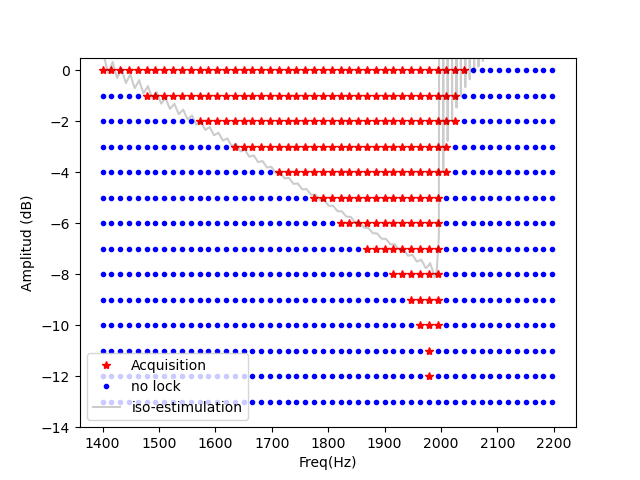

In [11]:
fig,ax = plt.subplots()

f = np.arange(1400.,2200.,Fs/Ncont*16.)
A = np.array([1, 0.5, 0.25, 0.125, 1./16., 1./32., 1./64., 1./128., 1./256., 1./512., 1./1024., 1./2048., 1./4096., 1./8192.])
# A = np.array([1, 0.5, 0.25, 0.125, 1./16., 1./32., 1./64. ])
lockmean = np.empty((len(f),len(A)))
si = 0
no = 0
for p in range(len(A)):
    print('\nA = {:f}'.format(A[p]))
    for k in range(len(f)):
        print('\rf = {:f}'.format(f[k]),end='')
        s = A[p]*np.sin(2*np.pi*f[k]*t)
        x[0,:] = sig.lfilter(np.real(hn),[1.],s)
        pll = bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
        pll.section_calc(x)
        #Check lockin after transit time of cochlear filter:
        lockmean[k,p] = np.mean(pll.lock[0,int(N*1.1):])
        if(lockmean[k,p]>0.0005):
            hsi, = ax.plot(f[k],np.log(A[p])/np.log(2.),'r*',label='Acquisition' if si == 0 else '_nolenged_')
            si = 1
        else:
            hno, = ax.plot(f[k],np.log(A[p])/np.log(2.),'b.',label='no lock' if no == 0 else '_nolenged_')
            no = 1
        ax.relim() 
        ax.autoscale_view(True,True,True) 
        # fig.canvas.draw()
        
fplot = om_c[::4]/(2*np.pi)
H_plot = H_v2[::4]

ax.plot(fplot[(fplot>=1400) & (fplot<=2200)],\
        -8.-2*np.log(np.abs(H_plot[(fplot>1400) & (fplot<=2200)])),'k',alpha=0.2,\
        label='iso-estimulation')
ax.set_xlabel('Freq(Hz)')
ax.set_ylabel('Amplitud (dB)')
ax.set_ylim((-14,0.5))
ax.legend()

fig.canvas.draw()

#### Examples positive slope:

Gray curve displays actual filter frequency response, displayed in logarithmic scale like an iso-stimulation curve. Ripple effect after cutoff freq is more notorious in this scale. Due mainly to the very low input signal energy, adquisition in this zone depends on several factors, including transient response, and the effective way we are using to decide that acquisition is acomplished. As lock indicator amplitud is related directly to the input signal amplitude, some times the right acquisition occurence criteria is difficult to determine. 
Following graphs are intended for illustration of that problem. Same amplitud ($A = 0.25$) and four consecutive frequencies coordinates are shown:

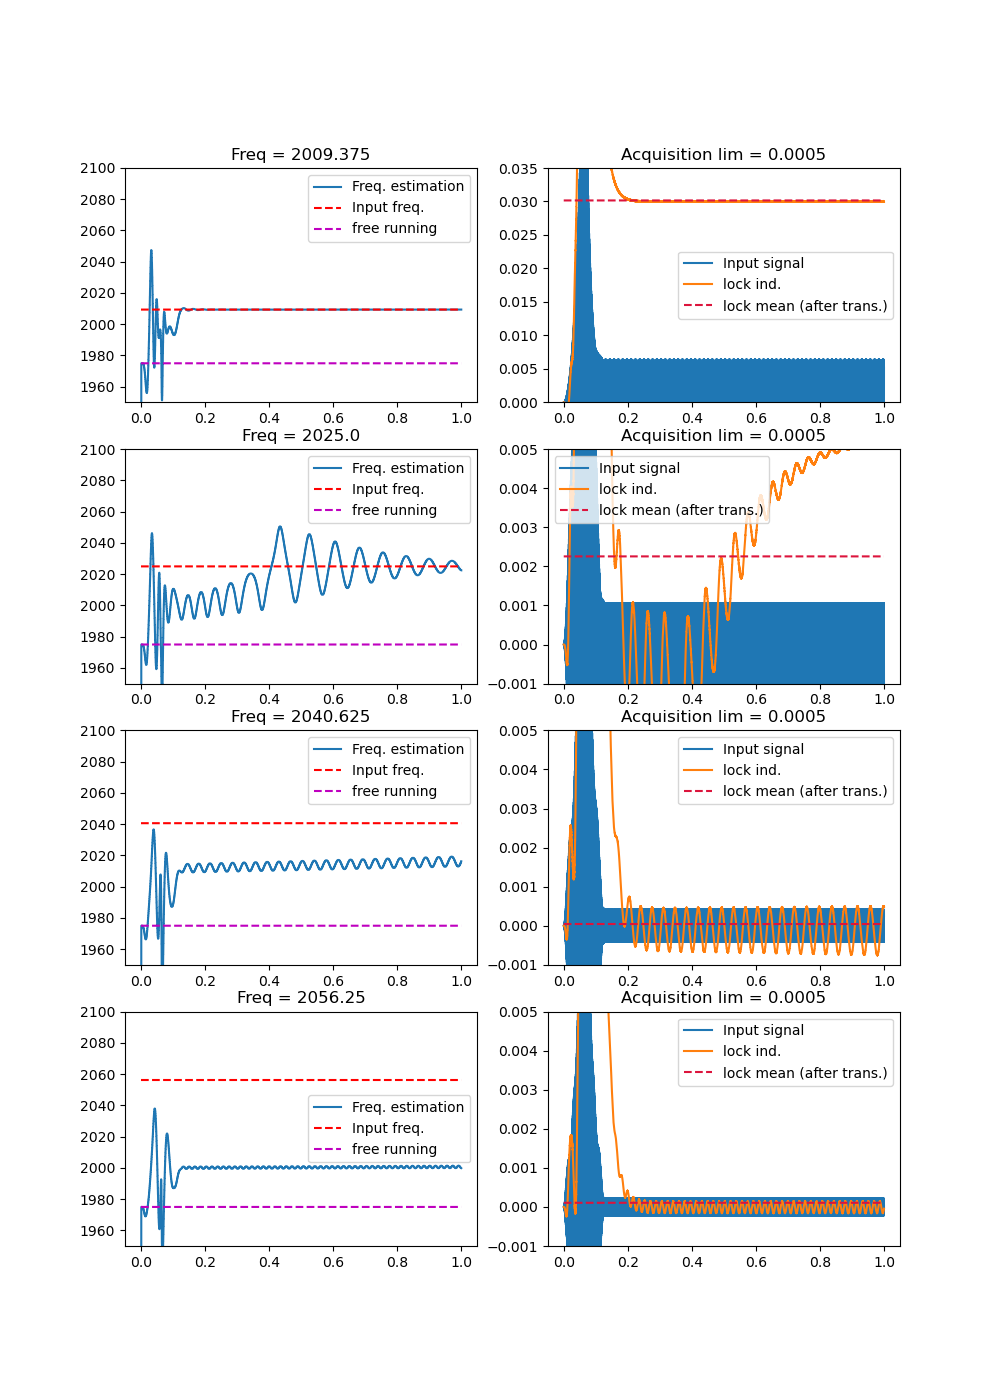

In [12]:
f = np.arange(1400.,2200.,Fs/Ncont*16.)
A = np.array([1, 0.5, 0.25, 0.125, 1./16., 1./32., 1./64., 1./128., 1./256., 1./512., 1./1024., 1./2048., 1./4096., 1./8192.])
Fo=1975

fig2,ax2 = plt.subplots(4,2,figsize=(10,14))
fig2.canvas.draw()
p = 2
n = 0
ex1 = 0
for k in range(-13,-9):
    s = A[p]*np.sin(2*np.pi*f[k]*t)
    x[0,:] = sig.lfilter(np.real(hn),[1.],s)
    B = np.max(x[0,-int(ltime/2):])
    pll = bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
    pll.section_calc(x)
    ax2[n,0].plot(t,pll.freq[0,:])
    ax2[n,0].plot(t,f[k]*np.ones(len(t)),'r--')
    ax2[n,0].plot(t,Fo*np.ones(len(t)),'m--')
    ax2[n,0].set_ylim((1950,2100))
    ax2[n,0].set_title('Freq = {}'.format(f[k]))
    ax2[n,1].set_title('Acquisition lim = 0.0005')
    ax2[n,1].plot(t,x[0,:])
    ax2[n,1].plot(t,pll.lock[0,:])
    ax2[n,1].plot(t,lockmean[len(f)+k,p]*np.ones(len(t)),'--',color= 'crimson')
    if (n == 0):
        ax2[n,1].set_ylim((0,0.035))
    else:
        ax2[n,1].set_ylim((-0.001,0.005))

    ax2[n,0].legend(('Freq. estimation','Input freq.','free running'))
    ax2[n,1].legend(('Input signal','lock ind.','lock mean (after trans.)'))
    ax.plot(f[k],np.log(A[p])/np.log(2.),marker='o',mec='darkgreen',ms=10,mfc='none',\
            markeredgewidth=2, ls='',label='Example pos. slope' if ex1 == 0 else '_nolegend_')
    ex1 = 1
    n += 1

ax.legend()

The first row of plots shows a clear adquisition case, in spite the very low input amplitude. In the second and third row, as the input signal amplitude is even lower than the previous frequency due to the fact that stimulus frequency is farther apart from peak frequency, lock in signal is weaker, and acquisition condition is almost achieved but not totally. Time lapse utilized in the experiment determines that acquisition occurs in the second case but not for the third one. Finally, the fourth case shows a clearly not acquired state. 

#### Examples negative slope:

These curves also illustrate the tuning curve phenomena at the other slope. As the stimulus frequency is further from free running frequency, in this case chosen as the peak of the input filter, acquisition is more difficult, or takes a longer time to be produced. This fact is observed in a persistent acquisition for very low amplitudes near peak, but failing to acquire for similar input amplitudes at the input filter output, but different frequencies. For example, in these cases five border points of different amplitudes are sketched:  

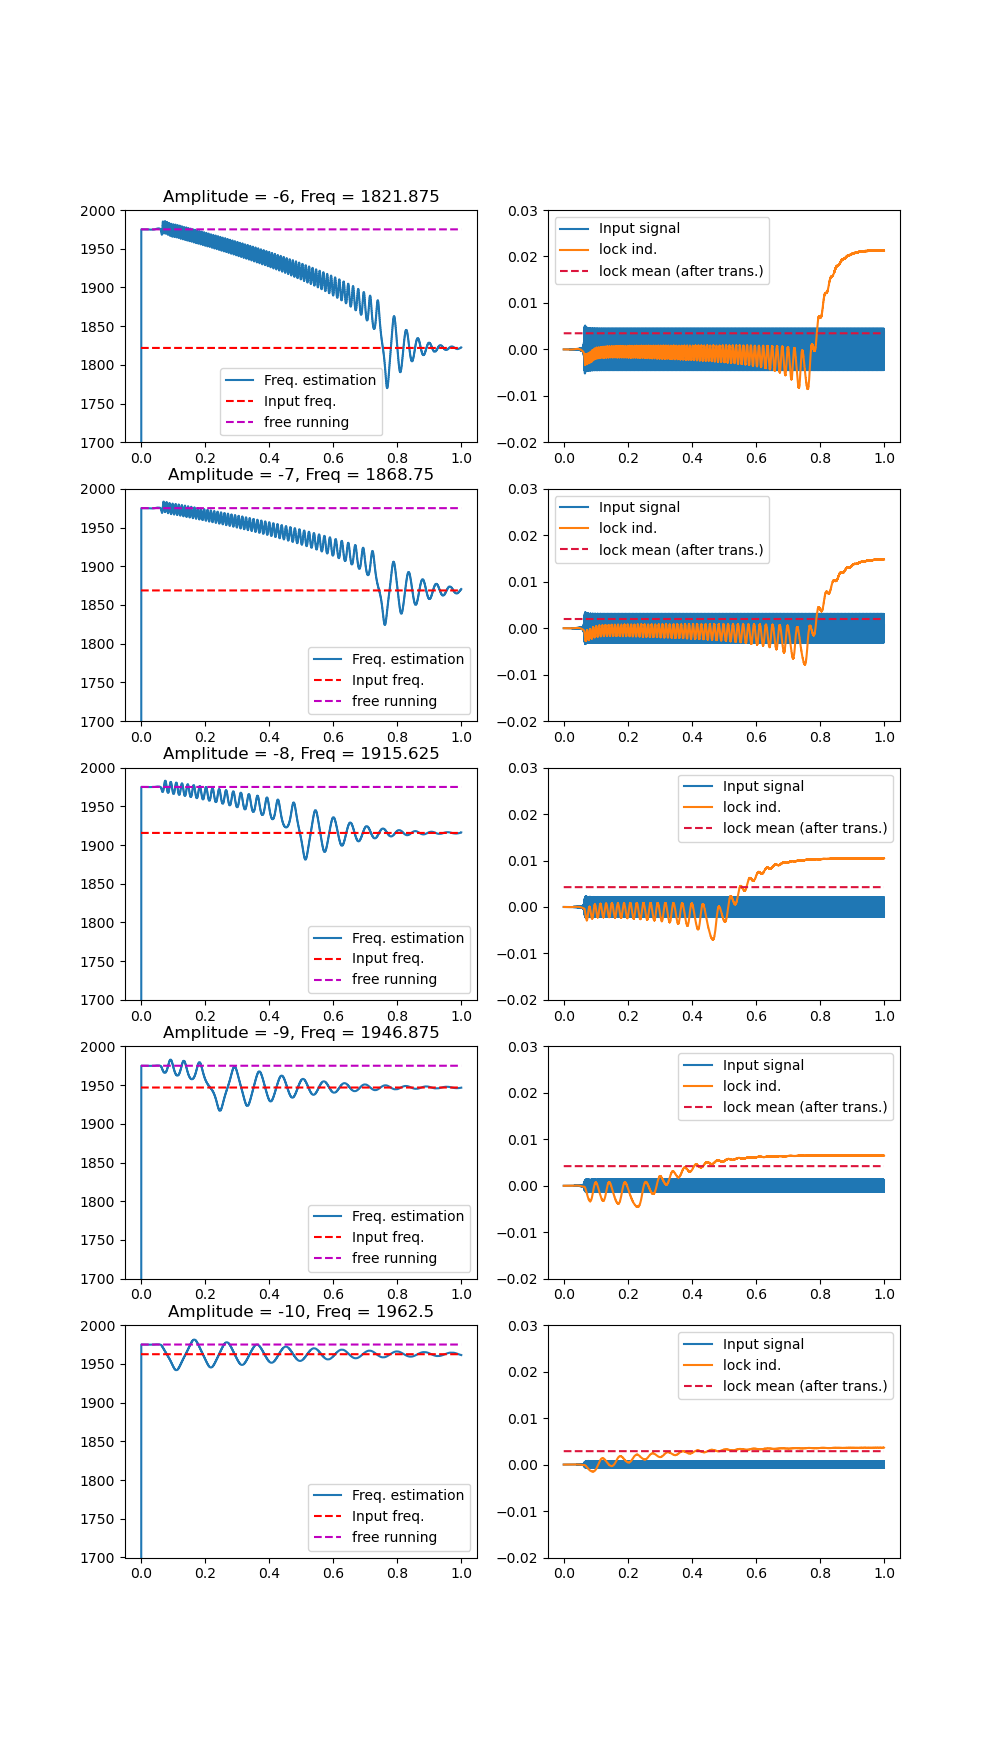

In [13]:
fig3,ax3 = plt.subplots(5,2,figsize=(10,17.5))
fig3.canvas.draw()

coords = [(6,27),(7,30),(8,33),(9,35),(10,36)]
n = 0
ex2 = 0
for pair in coords:
    s = A[pair[0]]*np.sin(2*np.pi*f[pair[1]]*t)
    x[0,:] = sig.lfilter(np.real(hn),[1.],s)
    B = np.max(x[0,-int(ltime/2):])
    pll = bank_pll(nplls = 1, ltime=ltime, sita=0.7, Fn=200., Fo=1975, fc_lock=4,Fs=16000)
    pll.section_calc(x)
    ax3[n,0].plot(t,pll.freq[0,:])
    ax3[n,0].plot(t,f[pair[1]]*np.ones(len(t)),'r--')
    ax3[n,0].plot(t,Fo*np.ones(len(t)),'m--')
    ax3[n,0].set_ylim((1700,2000))
    ax3[n,0].set_title('Amplitude = {:.0f}, Freq = {}'.format(np.log(A[pair[0]])/np.log(2.),f[pair[1]]))
    ax3[n,1].plot(t,x[0,:])
    ax3[n,1].plot(t,pll.lock[0,:])
    ax3[n,1].plot(t,lockmean[pair[1],pair[0]]*np.ones(len(t)),'--',color='crimson')
    ax3[n,1].set_ylim((-0.02,0.03))
    #     if (n == 0):
    #         ax[n,1].set_ylim((0,0.035))
    #     else:
    #         ax[n,1].set_ylim((-0.001,0.005))

    ax3[n,0].legend(('Freq. estimation','Input freq.','free running'))
    ax3[n,1].legend(('Input signal','lock ind.','lock mean (after trans.)'))
    ax.plot(f[pair[1]],np.log(A[pair[0]])/np.log(2.),marker='o',mec='darkmagenta',ms=10,mfc='none',\
           mew=2,ls='',label='Example neg. slope' if ex2 == 0 else '_nolegend_')
    ex2 = 1
    n += 1

ax.legend()


As can be noticed, these cases are in a sequence of less than iso-estimulation, as input amplitud in consecutive rows is decreasing. Iso-estimulation requires almost 3 or 4 frequency bins of separation between consecutive levels to be mantained (as shown in gray in the tuning curve graph). Here we have only 2 or even 1 for the two last rows. In spite of that, acquisition is mantained, mainly because energy necesary to move the internal oscilator from free runing to the acquired frequency is low.  